In [1]:
import sys
sys.path.append('/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/eth-capstone-treewater-deficit/src')
# sys.path.append('/workspaces/eth-capstone-treewater-deficit/src')
import os
import glob 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import plotly.express as px
import plotly.graph_objects as go

import collections

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras as tf_keras

from sklearn.preprocessing import StandardScaler
from treewater.utils import *

2025-12-30 13:45:29.632209: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-30 13:45:30.829586: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-30 13:45:34.732170: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import importlib
import treewater.utils as utils
importlib.reload(utils)

# check presence
print(hasattr(utils, "build_autoregressive_training_data_fast_LSTM_scheduled"))
print(hasattr(utils, "teacher_forcing_prob"))
print(hasattr(utils, "cross_validation_LSTM_FT"))

True
True
True


In [3]:
# set global random seed
seed = 66666
tf.random.set_seed(
    seed
)

In [4]:
# # At top of notebook
# %load_ext autoreload
# %autoreload 2

# from treewater.utils import *

In [5]:
derived_path = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data"
data_dir = "/cluster/home/taoj/work_dir/eth-caipstone/tree-water-deficit/data/tstoy04"
# data_dir = "/workspaces/eth-capstone-treewater-deficit/data/tstoy04"
# derived_path = "/workspaces/eth-capstone-treewater-deficit/data"

In [6]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [7]:
df_series_all.head(5)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_06,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_06,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


## data preparation

In [8]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [9]:
# twd_tree_series_sites

In [10]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [11]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

In [12]:
# create a dataframe with log2 transformed twd values
df_series_features_log2 = df_series_features.copy()
epsilon = 1e-6
df_series_features_log2['twd'] = np.log2(epsilon+ df_series_features_log2['twd'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [13]:
# Configure features
config = FeatureConfig()
lag_n =13

# Autoregressive
# Split data
train_df_at, val_df_at, test_df_at = create_training_test_set_optimized(
    df_series_features,
    feature_window_size=lag_n,
    autoregressive=True
)

train_df_at, val_df_at, test_df_at = standardize_dataset(
    train_df_at, val_df_at, test_df_at,
    config
)

# Create windows
train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at = get_dataset_LSTM(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)

val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at = get_dataset_LSTM(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)





2025-12-30 13:45:37.496795: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### build LSTM
- LSTM 
- RNN
- and perhaps try elastic net to improve ridgeregression model performance, and try gaussian regressor

In [14]:

batch_size = 64
lag_n = 13

### Autoregressive
- reduce hidden space size to prevent overfitting

In [15]:
# building datasets
batch_size = batch_size

train_ds_at = tf.data.Dataset.from_tensor_slices((
    (train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at),
    train_y_at,
))
train_ds_at = (
    train_ds_at
    .shuffle(buffer_size=len(train_X_ts_at))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_at = tf.data.Dataset.from_tensor_slices((
    (val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at),
    val_y_at,
))
val_ds_at = (
    val_ds_at
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# create cross validate datasets tensorflow datasets

train_val_datasets_at = cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df_at, val_cv_df_at in train_val_datasets_at:
    
    train_cv_ds_at = build_ds_from_get_dataset_LSTM(
        train_cv_df_at ,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    val_cv_ds_at = build_ds_from_get_dataset_LSTM(
        val_cv_df_at,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    cv_train_val_ds_at.append((train_cv_ds_at, val_cv_ds_at))

    

In [16]:
# dynamic input
def build_autoregressive_model_lstm( train_X_ts_at, train_day_feat_X, train_static_X_ts, lag_n, hidden_unit = 16):
     # we don't actually need the input features but rather the shape information
    timesteps = lag_n
    n_features = train_X_ts_at.shape[2] # include TWD + other variables

    dyn_in = tf_keras.layers.Input(shape=(timesteps, n_features), name="past_dynamic")
    x_dyn = tf_keras.layers.LSTM(hidden_unit, return_sequences=False)(dyn_in)
    x_dyn = tf_keras.layers.Dense(hidden_unit, activation="relu")(x_dyn)

    # current day other features
    n_static = train_day_feat_X.shape[1]
    static_in = tf_keras.Input(shape=(n_static,), name="current_day_exog")
    x_static = tf_keras.layers.Dense(4, 
                                     activation="relu",
                                     kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                     )(static_in)

    # static input
    n_current = train_static_X_ts.shape[1]
    curr_in = tf_keras.Input(shape=(n_current,), name="static")
    x_curr = tf_keras.layers.Dense(4, 
                                   activation="relu",
                                   kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                   )(curr_in)


    combined = tf_keras.layers.Concatenate()([x_dyn, x_static, x_curr])
    x = tf_keras.layers.Dense(16, activation="relu")(combined)
    out = tf_keras.layers.Dense(1, activation = "softplus")(x)


    model_at = tf_keras.Model(
    inputs=[dyn_in, static_in, curr_in],
    outputs=out,
    )

    model_at.compile(
        optimizer=tf_keras.optimizers.Adam(),
        loss="mae",
        metrics=[
        tf_keras.metrics.RootMeanSquaredError(name="rmse"),
        tf_keras.metrics.MeanAbsoluteError(name="mae"),
    ],
    )
    return model_at

In [17]:
# building datasets
batch_size = batch_size

train_ds_at = tf.data.Dataset.from_tensor_slices((
    (train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at),
    train_y_at,
))
train_ds_at = (
    train_ds_at
    .shuffle(buffer_size=len(train_X_ts_at))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_at = tf.data.Dataset.from_tensor_slices((
    (val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at),
    val_y_at,
))
val_ds_at = (
    val_ds_at
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# create cross validate datasets tensorflow datasets

train_val_datasets_at = cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df_at, val_cv_df_at in train_val_datasets_at:
    
    train_cv_ds_at = build_ds_from_get_dataset_LSTM(
        train_cv_df_at ,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    val_cv_ds_at = build_ds_from_get_dataset_LSTM(
        val_cv_df_at,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    cv_train_val_ds_at.append((train_cv_ds_at, val_cv_ds_at))

    



In [18]:
# create two models with different hidden units 

model_fold1 = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, lag_n, hidden_unit = 16)
maes_cv_at, rmses_cv_at, rmses_cv_1d_at, r2s_cv_1d_at, r2s_cv_at, y_preds_cv_at, y_trues_cv_at, historys_cv_at = cross_validation_LSTM(
    model_fold1,
    cv_train_val_ds_at,
    train_val_datasets_at,
    lag_n,
    config,
    batch_size
)

model_fold2 = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at , lag_n, hidden_unit = 32)
maes_cv_at2, rmses_cv_at2, rmses_cv_1d_at2, r2s_cv_1d_at2, r2s_cv_at2, y_preds_cv_at2, y_trues_cv_at2, historys_cv_at2  = cross_validation_LSTM(
    model_fold2,
    cv_train_val_ds_at,
    train_val_datasets_at,
    lag_n,
    config,
    batch_size
)


Training fold 1/4
Epoch 1/40


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6677 - mae: 0.6579 - rmse: 0.8639 - val_loss: 0.6496 - val_mae: 0.6401 - val_rmse: 0.7831
Epoch 2/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5513 - mae: 0.5420 - rmse: 0.7625 - val_loss: 0.4957 - val_mae: 0.4866 - val_rmse: 0.7132
Epoch 3/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4426 - mae: 0.4337 - rmse: 0.6464 - val_loss: 0.5021 - val_mae: 0.4933 - val_rmse: 0.7953
Epoch 4/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3595 - mae: 0.3508 - rmse: 0.5359 - val_loss: 0.5140 - val_mae: 0.5054 - val_rmse: 0.8306
Epoch 5/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3109 - mae: 0.3024 - rmse: 0.4676 - val_loss: 0.5149 - val_mae: 0.5065 - val_rmse: 0.8376
Epoch 6/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2842 - mae: 0.2758 - rmse: 0.4226 - val_loss: 0.5185 - val_mae: 0.5102 - val_rmse: 0.8467
Epoch 7/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2648 - mae: 0.2567 - rmse: 0.3864 - val_loss: 0.519

2025-12-30 13:45:49.788471: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training fold 2/4
Epoch 1/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1569 - mae: 0.1521 - rmse: 0.2356 - val_loss: 0.2324 - val_mae: 0.2276 - val_rmse: 0.3707
Epoch 2/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1440 - mae: 0.1393 - rmse: 0.2198 - val_loss: 0.2283 - val_mae: 0.2236 - val_rmse: 0.3742
Epoch 3/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1431 - mae: 0.1385 - rmse: 0.2171 - val_loss: 0.2279 - val_mae: 0.2234 - val_rmse: 0.3732
Epoch 4/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1340 - mae: 0.1296 - rmse: 0.2091 - val_loss: 0.2259 - val_mae: 0.2215 - val_rmse: 0.3734
Epoch 5/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1340 - mae: 0.1297 - rmse: 0.2092 - val_loss: 0.2268 - val_mae: 0.2226 - val_rmse: 0.3723
Epoch 6/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1345 - mae: 0.1302 - rmse: 0.2095 - val_loss: 0.2215 - val_mae: 0.2173 - val_rmse: 0.3617
Epoch 7/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1360 - mae: 0.1319 - r

2025-12-30 13:46:18.909446: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training fold 3/4
Epoch 1/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1270 - mae: 0.1245 - rmse: 0.2374 - val_loss: 0.1065 - val_mae: 0.1041 - val_rmse: 0.1809
Epoch 2/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1247 - mae: 0.1222 - rmse: 0.2345 - val_loss: 0.1017 - val_mae: 0.0993 - val_rmse: 0.1764
Epoch 3/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1212 - mae: 0.1188 - rmse: 0.2325 - val_loss: 0.1009 - val_mae: 0.0985 - val_rmse: 0.1753
Epoch 4/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1208 - mae: 0.1184 - rmse: 0.2319 - val_loss: 0.0996 - val_mae: 0.0972 - val_rmse: 0.1751
Epoch 5/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1203 - mae: 0.1180 - rmse: 0.2311 - val_loss: 0.1017 - val_mae: 0.0995 - val_rmse: 0.1777
Epoch 6/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1208 - mae: 0.1185 - rmse: 0.2313 - val_loss: 0.1060 - val_mae: 0.1038 - val_rmse: 0.1827
Epoch 7/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1207 - m

2025-12-30 13:47:33.349520: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training fold 1/4
Epoch 1/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5869 - mae: 0.5769 - rmse: 0.7920 - val_loss: 0.5398 - val_mae: 0.5299 - val_rmse: 0.7260
Epoch 2/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4922 - mae: 0.4824 - rmse: 0.6717 - val_loss: 0.5060 - val_mae: 0.4964 - val_rmse: 0.7491
Epoch 3/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3528 - mae: 0.3432 - rmse: 0.4861 - val_loss: 0.5115 - val_mae: 0.5020 - val_rmse: 0.8209
Epoch 4/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2927 - mae: 0.2833 - rmse: 0.4037 - val_loss: 0.5268 - val_mae: 0.5175 - val_rmse: 0.8591
Epoch 5/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2626 - mae: 0.2534 - rmse: 0.3618 - val_loss: 0.5339 - val_mae: 0.5248 - val_rmse: 0.8696
Epoch 6/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2417 - mae: 0.2326 - rmse: 0.3390 - val_loss: 0.5314 - val_mae: 0.5225 - val_rmse: 0.8615
Epoch 7/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2268 - mae: 0.2179 - 

2025-12-30 13:49:55.014986: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[Text(1, 0, 'hidden size =16'), Text(2, 0, 'hidden size =32')]

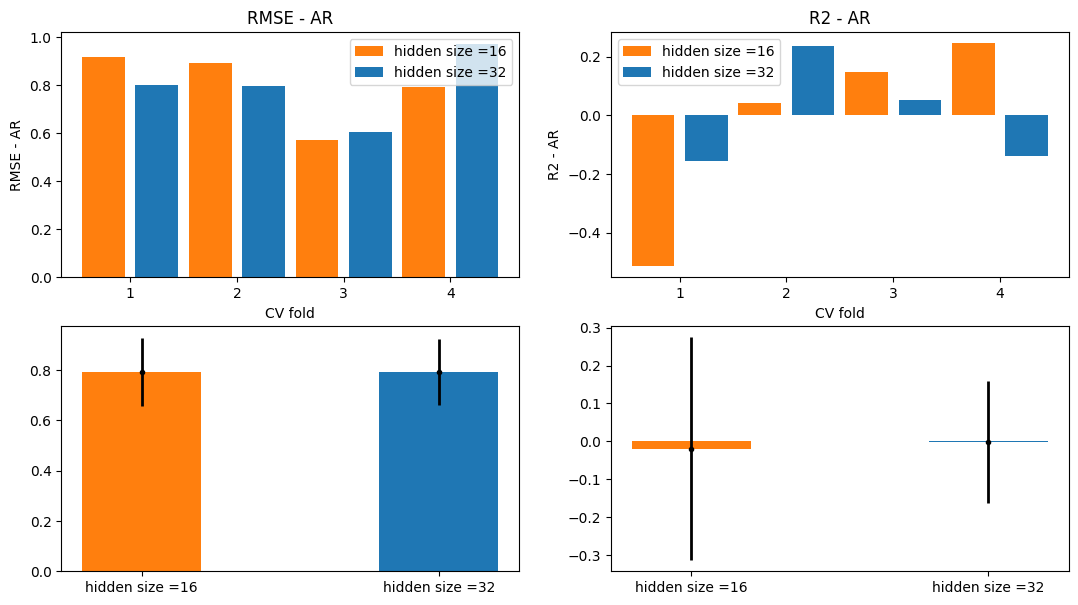

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 7))

ax1.bar(np.arange(0.75,4.75, 1), rmses_cv_at, color='tab:orange', width = 0.4)
ax1.bar(np.arange(1.25,5.25,1),rmses_cv_at2, color = "tab:blue", width = 0.4)

ax1.set_xticks(range(1,5))
ax1.legend(['hidden size =16', 'hidden size =32'])
ax1.set_ylabel('RMSE - AR')
ax1.set_xlabel("CV fold")
ax1.set_title("RMSE - AR")
# rmses_cv_at


ax2.bar(np.arange(0.75, 4.75, 1), r2s_cv_at, color='tab:orange', width = 0.4)
ax2.bar(np.arange(1.25,5.25,1),r2s_cv_at2, color = "tab:blue", width = 0.4)
ax2.set_xticks(range(1,5))
ax2.legend(['hidden size =16', 'hidden size =32'])
ax2.set_ylabel('R2 - AR')
ax2.set_xlabel("CV fold")
ax2.set_title("R2 - AR")   


ax3.bar([1,2],  [np.mean(rmses_cv_at), np.mean(rmses_cv_at2)],
       color=['tab:orange', 'tab:blue'], width = 0.4)
ax3.errorbar(x = [1,2], y = [np.mean(rmses_cv_at), np.mean(rmses_cv_at2)], 
             yerr=[np.std(rmses_cv_at), np.std(rmses_cv_at2)],
             fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1)
ax3.set_xticks([1,2])
ax3.set_xticklabels(['hidden size =16', 'hidden size =32'])


ax4.bar([1,2],  [np.mean(r2s_cv_at), np.mean(r2s_cv_at2)],
       color=['tab:orange', 'tab:blue'], width = 0.4)
ax4.errorbar(x = [1,2], y = [np.mean(r2s_cv_at), np.mean(r2s_cv_at2)], 
             yerr=[np.std(r2s_cv_at), np.std(r2s_cv_at2)],
             fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1)
ax4.set_xticks([1,2])
ax4.set_xticklabels(['hidden size =16', 'hidden size =32'])

- performance appears more stable when hidden space dimension is 32 

In [30]:
model_at = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, lag_n, hidden_unit = 16)
history_at = model_at.fit(
    train_ds_at,
    epochs=50,
    validation_data=val_ds_at,
)


Epoch 1/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3317 - mae: 0.3221 - rmse: 0.4972 - val_loss: 0.1877 - val_mae: 0.1789 - val_rmse: 0.2778
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1748 - mae: 0.1671 - rmse: 0.2791 - val_loss: 0.1497 - val_mae: 0.1428 - val_rmse: 0.2297
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1513 - mae: 0.1450 - rmse: 0.2564 - val_loss: 0.1269 - val_mae: 0.1213 - val_rmse: 0.2092
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1382 - mae: 0.1331 - rmse: 0.2454 - val_loss: 0.1188 - val_mae: 0.1142 - val_rmse: 0.2015
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1306 - mae: 0.1264 - rmse: 0.2390 - val_loss: 0.1140 - val_mae: 0.1101 - val_rmse: 0.1989
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1261 - mae: 0.1225 - rmse: 0.2351 - val_loss: 0.1112 - val_mae: 0.1079 - val_rmse: 0.1964
Epoch 7/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1224 - mae: 0.1194 - rmse:

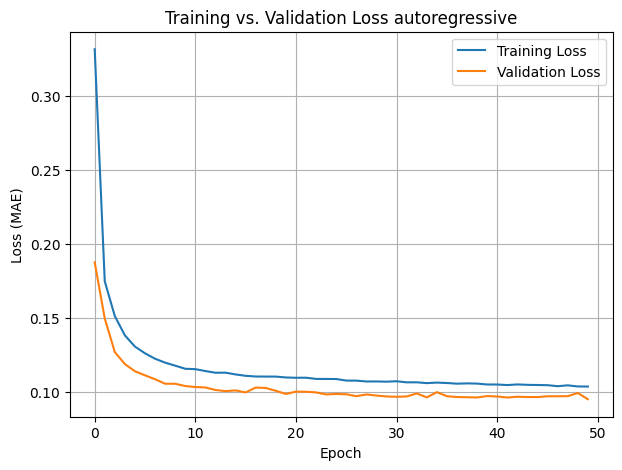

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
rmse: 0.184103, r2: 0.944670 


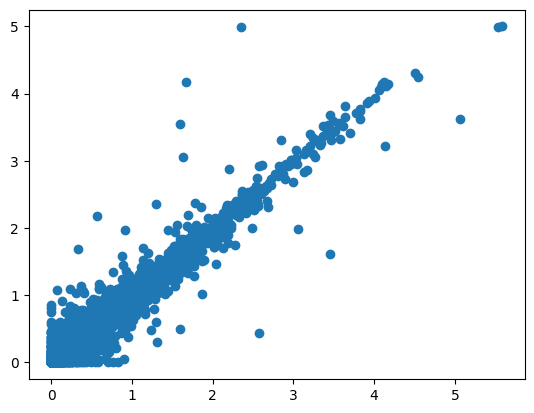

In [40]:


# Extract loss values
train_loss_at= history_at.history["loss"]
val_loss_at = history_at.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss_at, label="Training Loss")
plt.plot(val_loss_at, label="Validation Loss")
plt.title("Training vs. Validation Loss autoregressive")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.legend()
plt.grid(True)
plt.show()




y_pred_val_1day_at= model_at.predict(val_ds_at)# show first few predictions

rmse_1day_at = root_mean_squared_error(y_pred_val_1day_at, val_y_at)
r2_1day_at = r2_score(val_y_at, y_pred_val_1day_at)
print(f'rmse: {rmse_1day_at:3f}, r2: {r2_1day_at:3f} ')
plt.scatter(val_y_at, y_pred_val_1day_at)

In [32]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at, y_val_at = compute_recursive_predictions_fast_LSTM(model_at, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [33]:
r2_at = r2_score(y_val_at, y_pred_val_at)
rmse_at = root_mean_squared_error(y_val_at, y_pred_val_at)

print(f"r2: {r2_score(y_val_at, y_pred_val_at)}\n rmse: {root_mean_squared_error(y_val_at, y_pred_val_at)}")

r2: 0.5801705746862715
 rmse: 0.5185081159485648


### fine tune model with autoregressive training set 



add cross-validation

In [34]:
# build a fresh model with identical architecture
model_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=16,
)

# copy weights from model_at (teacher-forced trained model)
model_ar.set_weights(model_at.get_weights())

# fine tune the model within CV

maes_cv_at_finetune, rmses_cv_at_finetune, rmses_cv_1d_at_finetune, r2s_cv_1d_at_finetune, \
r2s_cv_at_finetune, y_preds_cv_at_finetune, y_trues_cv_at_finetune, historys_cv_at_finetune = cross_validation_LSTM_FT(
    model_ar,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    num_epochs=50,
    batch_size = batch_size
)



Training fold 1/4
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3411 - mae: 0.3405 - rmse: 0.5126 - val_loss: 0.1550 - val_mae: 0.1544 - val_rmse: 0.2399
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3214 - mae: 0.3208 - rmse: 0.4772 - val_loss: 0.1719 - val_mae: 0.1713 - val_rmse: 0.2701
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3043 - mae: 0.3038 - rmse: 0.4575 - val_loss: 0.1971 - val_mae: 0.1965 - val_rmse: 0.3035
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2949 - mae: 0.2943 - rmse: 0.4446 - val_loss: 0.2142 - val_mae: 0.2136 - val_rmse: 0.3255
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2869 - mae: 0.2864 - rmse: 0.4340 - val_loss: 0.2341 - val_mae: 0.2335 - val_rmse: 0.3537
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2821 - mae: 0.2815 - rmse: 0.4275 - val_loss: 0.2425 - val_mae: 0.2419 - val_rmse: 0.3726
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2774 - mae: 0.2768 - 

In [35]:
X_dyn_ar, X_day_ar, X_static_ar, y_ar = build_autoregressive_training_data_fast_LSTM(
    model=model_at,
    df=train_df_at,
    feature_window_size=lag_n,
    label_window_size=1,
    shift=1,
    config=config,
    batch_size=64,
)

ds_ar = tf.data.Dataset.from_tensor_slices(
    ((X_dyn_ar, X_day_ar, X_static_ar), y_ar)
).batch(64).prefetch(tf.data.AUTOTUNE)

In [36]:
# train final model on the full training set with AR-corrupted data
E2 = 50

# build a fresh model with identical architecture
model_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=16,
)

# copy weights from model_at (teacher-forced trained model)
model_ar.set_weights(model_at.get_weights())

# now fine-tune on AR-corrupted dataset
model_ar.fit(
    ds_ar,
    epochs=E2,
    validation_data=val_ds_at
)


Epoch 1/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3087 - mae: 0.3082 - rmse: 0.5015 - val_loss: 0.2330 - val_mae: 0.2324 - val_rmse: 0.3619
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3067 - mae: 0.3061 - rmse: 0.5005 - val_loss: 0.2116 - val_mae: 0.2110 - val_rmse: 0.3320
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3026 - mae: 0.3020 - rmse: 0.4959 - val_loss: 0.1879 - val_mae: 0.1873 - val_rmse: 0.2997
Epoch 4/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2995 - mae: 0.2989 - rmse: 0.4913 - val_loss: 0.1900 - val_mae: 0.1894 - val_rmse: 0.3031
Epoch 5/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2991 - mae: 0.2984 - rmse: 0.4909 - val_loss: 0.1907 - val_mae: 0.1900 - val_rmse: 0.3058
Epoch 6/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2978 - mae: 0.2971 - rmse: 0.4896 - val_loss: 0.1899 - val_mae: 0.1892 - val_rmse: 0.3062
Epoch 7/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2967 - mae: 0.2960 - rmse:

In [37]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_FT, y_val_at_FT = compute_recursive_predictions_fast_LSTM(model_ar, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [38]:
r2_FT = r2_score(y_val_at_FT, y_pred_val_at_FT)
rmse_FT = root_mean_squared_error(y_val_at_FT, y_pred_val_at_FT)

print(f"r2: {r2_score(y_val_at_FT, y_pred_val_at_FT)}\n rmse: {root_mean_squared_error(y_val_at_FT, y_pred_val_at_FT)}")

r2: 0.06553777246541337
 rmse: 0.773570673315412


### scheduled sampling - train model

cross validation - implement cross validation

In [ ]:
num_epochs = 45

# init model with same architecture
model_at_ar_cv = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=16,
)
# copy weights from model_at (teacher-forced trained model)
model_at_ar_cv.set_weights(model_at.get_weights())

maes_cv_at_ar, rmses_cv_at_ar, rmses_cv_1d_at_ar, r2s_cv_1d_at_ar, \
r2s_cv_at_ar, y_preds_cv_at_ar, y_trues_cv_at_ar, historys_cv_at_ar = cross_validation_LSTM_AR(
    model_at_ar_cv,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    num_epochs=num_epochs,
    batch_size = batch_size,
    p_min = 0.2,
    warmup_epochs=2,
    frac_decay=0.9,
    slow_decay=True
    )




Training fold 1/4
Epoch 43/45 - loss: 0.2819 - rmse: 0.4845 - val_loss: 0.1730 - val_rmse: 0.2920 - p_tf: 0.200
Epoch 44/45 - loss: 0.3024 - rmse: 0.4855 - val_loss: 0.2601 - val_rmse: 0.4637 - p_tf: 0.200
Epoch 45/45 - loss: 0.2825 - rmse: 0.4919 - val_loss: 0.1967 - val_rmse: 0.3132 - p_tf: 0.200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Training fold 4/4
Epoch 1/45 - loss: 0.1396 - rmse: 0.2465 - val_loss: 0.1615 - val_rmse: 0.2804 - p_tf: 1.000
Epoch 2/45 - loss: 0.1115 - rmse: 0.2101 - val_loss: 0.1435 - val_rmse: 0.2610 - p_tf: 1.000
Epoch 3/45 - loss: 0.1111 - rmse: 0.2142 - val_loss: 0.1320 - val_rmse: 0.2526 - p_tf: 0.886
Epoch 4/45 - loss: 0.1078 - rmse: 0.2113 - val_loss: 0.1289 - val_rmse: 0.2514 - p_tf: 0.886
Epoch 5/45 - loss: 0.1059 - rmse: 0.2090 - val_loss: 0.1274 - val_rmse: 0.2515 - p_tf: 0.886
Epoch 6/45 - loss: 0.1056 - rmse: 0.2092 - val_loss: 0.1308 - val_rmse: 0.2531 - p_tf: 0.886
Epoch 7/45 - loss: 0.1039 - rmse: 0.2063 - val_loss: 0.1253 - val_rmse: 0.2491 - p_tf

Epoch 1/45 - loss: 0.1010 - rmse: 0.1893 - val_loss: 0.1200 - val_rmse: 0.1918 - p_tf: 1.000
Epoch 2/45 - loss: 0.0983 - rmse: 0.1862 - val_loss: 0.1140 - val_rmse: 0.1891 - p_tf: 1.000
Epoch 3/45 - loss: 0.1011 - rmse: 0.1892 - val_loss: 0.1148 - val_rmse: 0.1876 - p_tf: 0.886
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/cluster/home/taoj/env/lib/python3.11/site-packages/keras/src/backend/tensorflow/rnn.py", line 418, in <genexpr>
    output_ta_t = tuple(  File "/cluster/home/taoj/env/lib/python3.11/site-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
Epoch 4/45 - loss: 0.0991 - rmse: 0.1876 - val_loss: 0.1124 - val_rmse: 0.1854 - p_tf: 0.886


2025-12-30 14:12:29.931298: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5/45 - loss: 0.0992 - rmse: 0.1870 - val_loss: 0.1163 - val_rmse: 0.1924 - p_tf: 0.886
Epoch 6/45 - loss: 0.0983 - rmse: 0.1855 - val_loss: 0.1165 - val_rmse: 0.1917 - p_tf: 0.886
Epoch 7/45 - loss: 0.0977 - rmse: 0.1850 - val_loss: 0.1140 - val_rmse: 0.1871 - p_tf: 0.886
Epoch 8/45 - loss: 0.1065 - rmse: 0.1976 - val_loss: 0.1182 - val_rmse: 0.1956 - p_tf: 0.771
Epoch 9/45 - loss: 0.1060 - rmse: 0.1953 - val_loss: 0.1200 - val_rmse: 0.1952 - p_tf: 0.771
Epoch 10/45 - loss: 0.1044 - rmse: 0.1932 - val_loss: 0.1219 - val_rmse: 0.2023 - p_tf: 0.771
Epoch 11/45 - loss: 0.1035 - rmse: 0.1936 - val_loss: 0.1202 - val_rmse: 0.1973 - p_tf: 0.771
Epoch 12/45 - loss: 0.1024 - rmse: 0.1914 - val_loss: 0.1198 - val_rmse: 0.1956 - p_tf: 0.771
Epoch 13/45 - loss: 0.1110 - rmse: 0.2065 - val_loss: 0.1226 - val_rmse: 0.1995 - p_tf: 0.657
Epoch 14/45 - loss: 0.1113 - rmse: 0.2074 - val_loss: 0.1245 - val_rmse: 0.2012 - p_tf: 0.657
Epoch 15/45 - loss: 0.1099 - rmse: 0.2046 - val_loss: 0.1276 - va

2025-12-30 14:21:35.549877: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 37/45 - loss: 0.3580 - rmse: 0.5594 - val_loss: 0.2968 - val_rmse: 0.5249 - p_tf: 0.200
Epoch 38/45 - loss: 0.3165 - rmse: 0.5551 - val_loss: 0.1942 - val_rmse: 0.3334 - p_tf: 0.200
Epoch 39/45 - loss: 0.3887 - rmse: 0.6074 - val_loss: 0.4350 - val_rmse: 0.7165 - p_tf: 0.200
Epoch 40/45 - loss: 0.3818 - rmse: 0.6431 - val_loss: 0.2446 - val_rmse: 0.4124 - p_tf: 0.200
Epoch 41/45 - loss: 0.4122 - rmse: 0.6010 - val_loss: 0.4807 - val_rmse: 0.7945 - p_tf: 0.200
Epoch 42/45 - loss: 0.3614 - rmse: 0.6113 - val_loss: 0.3288 - val_rmse: 0.5703 - p_tf: 0.200
Epoch 43/45 - loss: 0.3404 - rmse: 0.5021 - val_loss: 0.4334 - val_rmse: 0.7255 - p_tf: 0.200
Epoch 44/45 - loss: 0.3199 - rmse: 0.5471 - val_loss: 0.2913 - val_rmse: 0.5021 - p_tf: 0.200
Epoch 45/45 - loss: 0.3213 - rmse: 0.4894 - val_loss: 0.4187 - val_rmse: 0.7087 - p_tf: 0.200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training fold 2/4
Epoch 1/45 - loss: 0.1575 - rmse: 0.2620 - val_loss: 0.2052 - val_rmse: 0.3511 - p_tf: 1.000
Epoc

- more epochs, decay slower, stepwise training 
- hidden size 16, shorter window

In [ ]:
# now do scheduled sampling training on the full training set
num_epochs = 120

history_ar_at = {
"loss": [],
"rmse": [],
"val_loss": [],
"val_rmse": [],
"p_tf": []
}


# init model with same architecture
model_at_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=16,
)
# copy weights from model_at (teacher-forced trained model)
model_at_ar.set_weights(model_at.get_weights())



for epoch in range(num_epochs):
        # train model with teacher forcing for the first epoch 
    p_tf = teacher_forcing_prob_stepwise(epoch, num_epochs, epoch_per_step = 15, step_size = 0.1, p0=1.0, p_min=0.15, warmup_epochs=3, frac_decay=0.9)
    history_ar_at["p_tf"].append(p_tf)

    # rebuild AR / scheduled-sampling training data
    X_dyn_ar_at, X_day_ar_at, X_static_ar_at, y_ar_at = build_autoregressive_training_data_fast_LSTM_scheduled(
        model_at_ar,
        train_df_at,
        feature_window_size=lag_n,
        label_window_size=1,
        shift=1,
        config=config,
        batch_size=batch_size,
        teacher_forcing_prob=p_tf,
    )

    train_ds_at_decay = (
        tf.data.Dataset.from_tensor_slices(((X_dyn_ar_at, X_day_ar_at, X_static_ar_at), y_ar_at))
        .shuffle(len(X_dyn_ar_at))
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    # one epoch of manual training
    epoch_loss = tf.keras.metrics.Mean()
    epoch_rmse = tf.keras.metrics.RootMeanSquaredError()

    for (x_dyn, x_day, x_stat), y in train_ds_at_decay:
        with tf.GradientTape() as tape:
            preds = model_at_ar([x_dyn, x_day, x_stat], training=True)
            loss = model_at_ar.compute_loss(x=None, y=y, y_pred=preds, sample_weight=None, training=True)

        grads = tape.gradient(loss, model_at_ar.trainable_variables)
        model_at_ar.optimizer.apply_gradients(zip(grads, model_at_ar.trainable_variables))      
        epoch_loss.update_state(loss)
        epoch_rmse.update_state(y, preds)

    # validation
    val_loss_metric = tf.keras.metrics.Mean()
    val_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    for (x_dyn_v, x_day_v, x_stat_v), y_v in val_ds_at:
        preds_v = model_at_ar([x_dyn_v, x_day_v, x_stat_v], training=False)
        v_loss = model_at_ar.compute_loss(x=None, y=y_v, y_pred=preds_v, sample_weight=None, training=False)
        val_loss_metric.update_state(v_loss)
        val_rmse_metric.update_state(y_v, preds_v)

    history_ar_at["loss"].append(epoch_loss.result().numpy())
    history_ar_at["rmse"].append(epoch_rmse.result().numpy())
    history_ar_at["val_loss"].append(val_loss_metric.result().numpy())
    history_ar_at["val_rmse"].append(val_rmse_metric.result().numpy())
    history_ar_at["p_tf"].append(p_tf)

    print(
        f"Epoch {epoch+1}/{num_epochs} - "
        f"loss: {history_ar_at['loss'][-1]:.4f} - rmse: {history_ar_at['rmse'][-1]:.4f} - "
        f"val_loss: {history_ar_at['val_loss'][-1]:.4f} - val_rmse: {history_ar_at['val_rmse'][-1]:.4f} - "
        f"p_tf: {p_tf:.3f}"
    )

Epoch 1/120 - loss: 0.1030 - rmse: 0.2132 - val_loss: 0.0965 - val_rmse: 0.1840 - p_tf: 1.000
Epoch 2/120 - loss: 0.1034 - rmse: 0.2125 - val_loss: 0.0974 - val_rmse: 0.1866 - p_tf: 1.000
Epoch 3/120 - loss: 0.1028 - rmse: 0.2128 - val_loss: 0.0986 - val_rmse: 0.1860 - p_tf: 1.000
Epoch 4/120 - loss: 0.1101 - rmse: 0.2261 - val_loss: 0.0962 - val_rmse: 0.1852 - p_tf: 0.879
Epoch 5/120 - loss: 0.1101 - rmse: 0.2277 - val_loss: 0.1001 - val_rmse: 0.1893 - p_tf: 0.879
Epoch 6/120 - loss: 0.1091 - rmse: 0.2256 - val_loss: 0.0968 - val_rmse: 0.1860 - p_tf: 0.879
Epoch 7/120 - loss: 0.1097 - rmse: 0.2251 - val_loss: 0.0976 - val_rmse: 0.1843 - p_tf: 0.879
Epoch 8/120 - loss: 0.1086 - rmse: 0.2237 - val_loss: 0.0967 - val_rmse: 0.1850 - p_tf: 0.879
Epoch 9/120 - loss: 0.1102 - rmse: 0.2311 - val_loss: 0.0967 - val_rmse: 0.1841 - p_tf: 0.879
Epoch 10/120 - loss: 0.1098 - rmse: 0.2262 - val_loss: 0.0957 - val_rmse: 0.1860 - p_tf: 0.879
Epoch 11/120 - loss: 0.1093 - rmse: 0.2263 - val_loss: 0.09

In [51]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_ar, y_val_at_ar= compute_recursive_predictions_fast_LSTM(model_at_ar, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)
r2_at_ar = r2_score(y_val_at_ar, y_pred_val_at_ar)
rmse_at_ar = root_mean_squared_error(y_val_at_ar, y_pred_val_at_ar)

print(f"r2: {r2_at_ar}\n rmse: {rmse_at_ar}")

r2: -0.6242178634908928
 rmse: 1.0198616533036449


In [56]:
# plot performance together

df_model_performance = pd.DataFrame({
    "model" :['teacher_forcing (hidden=16)'] *4 + ['teacher_forcing (hidden=32)'] *4 + ['fine_tuned (hidden=16)'] *4 + ['scheduled_sampling (hidden=16)'] *4,    
    "cv_fold"  : [i for i in range(1, len(maes_cv_at_ar) + 1)] *4,
    "mae": maes_cv_at + maes_cv_at2 + maes_cv_at_finetune + maes_cv_at_ar,
    "rmse_recursive": rmses_cv_at + rmses_cv_at2 + rmses_cv_at_finetune + rmses_cv_at_ar,
    "rmse_1day": rmses_cv_1d_at + rmses_cv_1d_at2 + rmses_cv_1d_at_finetune + rmses_cv_1d_at_ar,
    "r2_1day" : r2s_cv_1d_at + r2s_cv_1d_at2 + r2s_cv_1d_at_finetune + r2s_cv_1d_at_ar,
    "r2_recursive": r2s_cv_at + r2s_cv_at2 + r2s_cv_at_finetune + r2s_cv_at_ar,
}
)

df_model_p_long = df_model_performance.melt(id_vars=["model", "cv_fold"], 
                                        value_vars=["mae", "rmse_recursive", "rmse_1day", "r2_1day", "r2_recursive"],
                                        var_name="metric",
                                        value_name="value"
                                        )

In [57]:
df_model_p_long.loc[df_model_p_long.metric == "r2_recursive",]

,model,cv_fold,metric,value
64,teacher_forcing (hidden=16),1,r2_recursive,-0.512989
65,teacher_forcing (hidden=16),2,r2_recursive,0.041680
66,teacher_forcing (hidden=16),3,r2_recursive,0.148561
67,teacher_forcing (hidden=16),4,r2_recursive,0.244827
68,teacher_forcing (hidden=32),1,r2_recursive,-0.155139
69,teacher_forcing (hidden=32),2,r2_recursive,0.236661
70,teacher_forcing (hidden=32),3,r2_recursive,0.052193
71,teacher_forcing (hidden=32),4,r2_recursive,-0.139519
72,fine_tuned (hidden=16),1,r2_recursive,-0.416346
73,fine_tuned (hidden=16),2,r2_recursive,0.365860


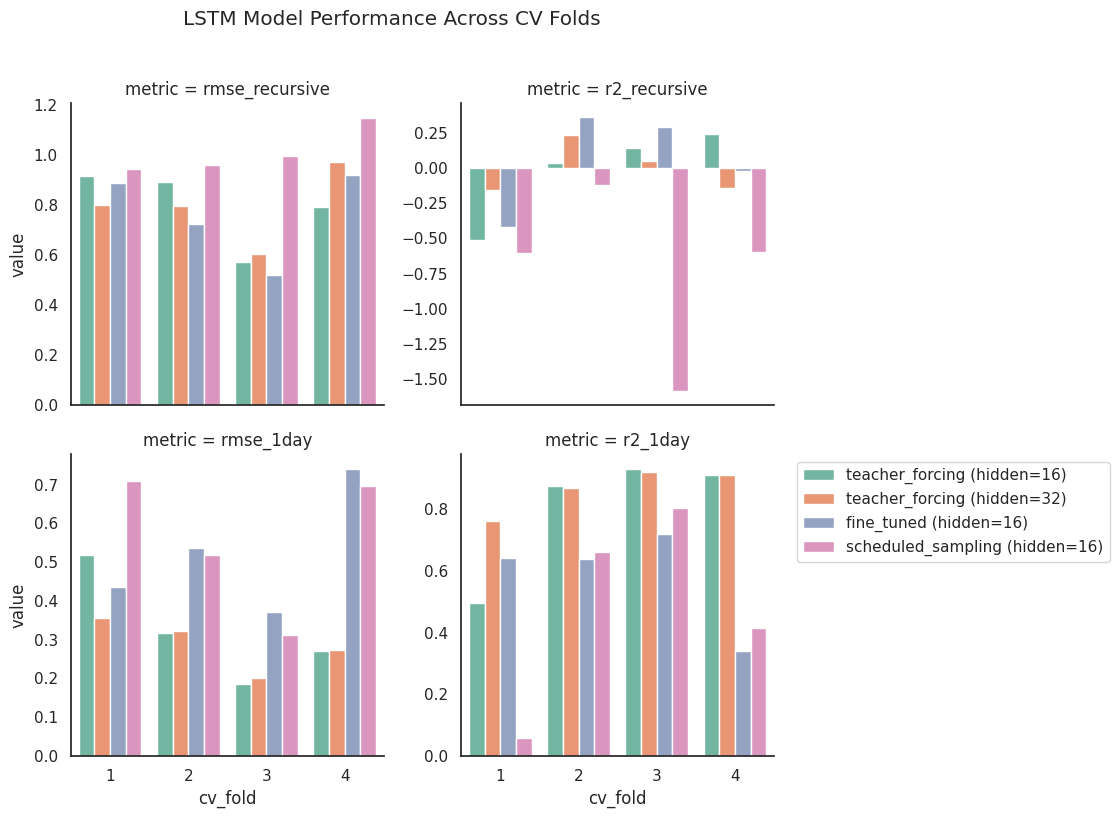

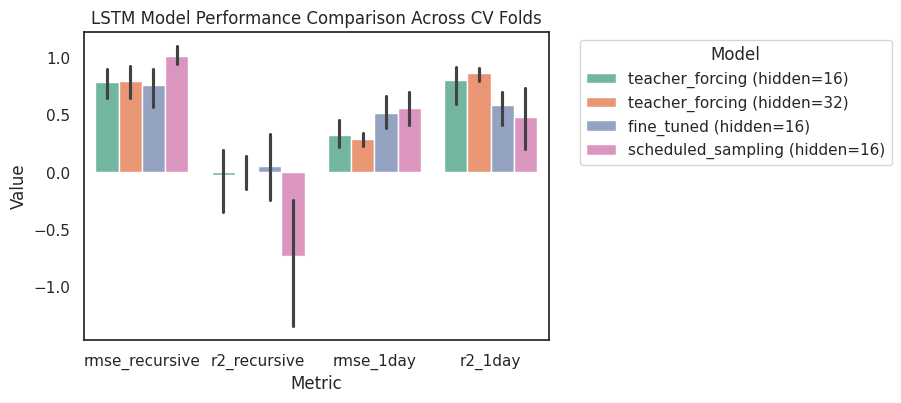

In [58]:
sns.set(style="white", font_scale=1,
        rc={"figure.figsize": (6, 4)})

metrics_plot = ['rmse_recursive', 'r2_recursive', 'rmse_1day', 'r2_1day']
df_p_plot = df_model_p_long.loc[df_model_p_long['metric'].isin(
metrics_plot
)]  
g = sns.FacetGrid(df_p_plot, col="metric", col_wrap = 2,
              col_order = metrics_plot,
              height=4, sharey=False).map_dataframe(
    sns.barplot,
    x="cv_fold",
    y="value",
    hue = 'model',
    palette = "Set2",
    legend = True,
)

g.figure.suptitle("LSTM Model Performance Across CV Folds", y=1.02)


plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

sns.barplot(df_p_plot, x="metric", y="value", hue="model", palette="Set2",
            order = metrics_plot)
plt.title("LSTM Model Performance Comparison Across CV Folds")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1))
plt.show()


/scratch/tmp.52887687.taoj/ipykernel_1631847/2033151881.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/scratch/tmp.52887687.taoj/ipykernel_1631847/2033151881.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.52887687.taoj/ipykernel_1631847/2033151881.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.52887687.taoj/ipykernel_1631847/2033151881.py:34: UserWarning: color is redundantly defined by the 'color' k

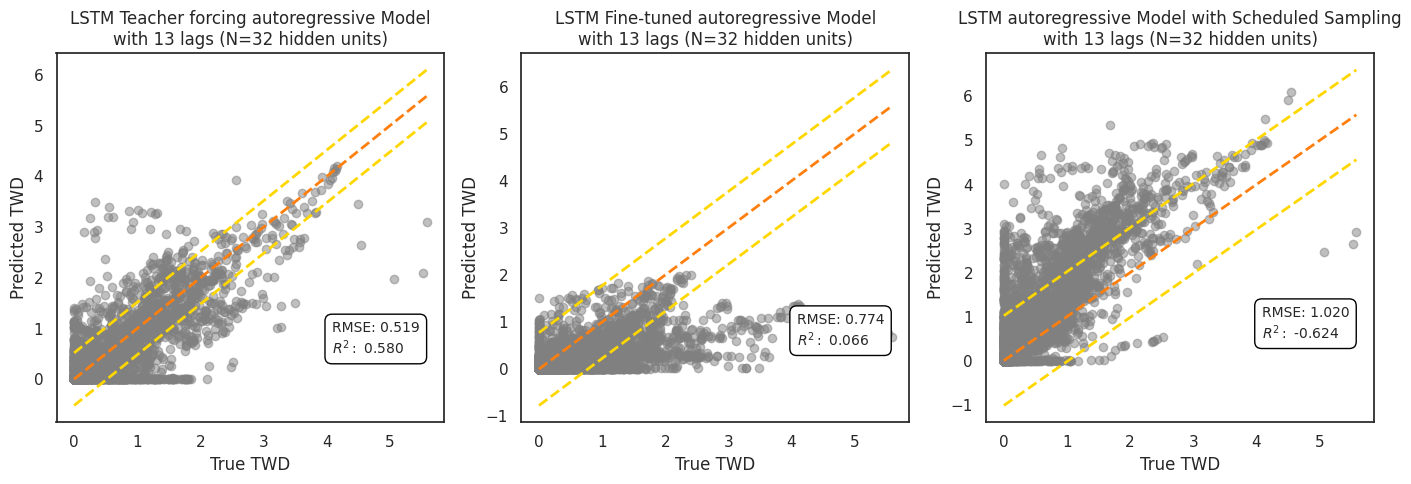

In [59]:
# Create figure with 3 subplots showing model final performance

def ensure_numpy(x):
    if isinstance(x, tf.Tensor):
        return x.numpy()
    return np.asarray(x)
y_val_at = ensure_numpy(y_val_at).reshape(-1)
y_pred_val_at = ensure_numpy(y_pred_val_at).reshape(-1)
# val_y = ensure_numpy(val_y)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(14, 5))


# First subplot - Autoregressive Model Predictions hidden 32
ax1.scatter(x=y_val_at, y=y_pred_val_at, color="grey", alpha=0.5)
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [y_val_at.min(), y_val_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"LSTM Teacher forcing autoregressive Model\nwith {lag_n} lags (N=32 hidden units)")
ax1.text(y_val_at.max()-1.5,y_pred_val_at.min()+0.5, 
         f"RMSE: {rmse_at:.3f}\n$R^2:$ {r2_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# plot fine-tuned 
ax2.scatter(x =  y_val_at_FT, y = y_pred_val_at_FT, color="grey", alpha=0.5)
ax2.set_xlabel("True TWD")
ax2.set_ylabel("Predicted TWD")
x_range = [y_val_at_FT.min(), y_val_at_FT.max()]
ax2.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax2.plot(x_range, [i+rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.plot(x_range, [i-rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.set_title(f"LSTM Fine-tuned autoregressive Model\nwith {lag_n} lags (N=32 hidden units)")
ax2.text(y_val_at_FT.max()-1.5,y_pred_val_at_FT.min()+0.5, 
         f"RMSE: {rmse_FT:.3f}\n$R^2:$ {r2_FT:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))   


# plot scheduled sampling 
ax3.scatter(x = y_val_at_ar, y = y_pred_val_at_ar, color="grey", alpha=0.5)
ax3.set_xlabel("True TWD")
ax3.set_ylabel("Predicted TWD")
x_range = [y_val_at_ar.min(), y_val_at_ar.max()]
ax3.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax3.plot(x_range, [i+rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.plot(x_range, [i-rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.set_title(f"LSTM autoregressive Model with Scheduled Sampling\nwith {lag_n} lags (N=32 hidden units)")
ax3.text(y_val_at_ar.max()-1.5,y_pred_val_at_ar.min()+0.5, 
         f"RMSE: {rmse_at_ar:.3f}\n$R^2:$ {r2_at_ar:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))  

plt.tight_layout()
plt.show()



- timeseries prediction across timestep 

why the performance is so bad ..
- try the same on ridge regression?

to improve the model performance
- we can try to improve the LSTM architecture 
    -  added softplus - why it lowered the performance? 
    - play with the architecture and hyperparameter
- add also compute the correlation matrix of lagged features with twd
- should I create cross-validation function to choose the tune the model?
- how can i integrate autoregressive training?
- incorporate log value into traning 
- stack layers? 
- how to extrapolate if i use location and other static parameters in the future?
- perturbation to analyze feature importance